In [1]:
import iris
import iris.analysis.stats as istats
import warnings
import matplotlib.pyplot as plt
import numpy as np
import iris.plot as iplt
import cartopy.crs as ccrs
import os
import datetime as dt
import cmocean

In [7]:
def callback(cube,field,filename):
    cube1 = cube.extract(iris.Constraint(longitude=lambda x: x>=0))
    cube2 = cube.extract(iris.Constraint(longitude=lambda x: x<0))
    cube2.coord('longitude').points = cube2.coord('longitude').points + 360
    if cube2.coord('longitude').has_bounds():
        cube2.coord('longitude').bounds = cube2.coord('longitude').bounds + 360
    return iris.cube.CubeList([cube1,cube2]).concatenate_cube()

In [3]:
alpha_w = iris.coords.AuxCoord(1/1000.,units='m**3*kg**-1')
cmip_info = {"ACCESS-CM2":("CSIRO-ARCCSS","r4i1p1f1"),"ACCESS-ESM1-5":('CSIRO','r6i1p1f1'),'NorESM2-MM':('NCC','r1i1p1f1')}
def load_cmip6(scenario,model,stream,var,t_s,t_e,Constraints,template=None,lapse=None,regrid_method=iris.analysis.Linear(),callback=None):
    group,rev  = cmip_info[model]
    if scenario == 'historical':
        mip = "CMIP"
    else:
        mip = "ScenarioMIP"
    path = "/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/{stream}/{var}/gn/latest/".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    filepart = "{var}_{stream}_{model}_{scenario}_{rev}_gn".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model)
    try:
        files = [f for f in os.listdir(path) if filepart in f]
    except:
        path = path.replace('latest','v20191108')
        files = [f for f in os.listdir(path) if filepart in f]
    starts = [f.split("_")[-1].split("-")[0] for f in files]
    ends = [f.split("_")[-1].split("-")[1] for f in files]
    starts = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in starts]
    ends = [dt.datetime(int(x[:4]),int(x[4:6]),1) for x in ends]
    files = [ os.path.join(path,f) for (i,f) in enumerate(files) if ((t_e  - starts[i]).days >0  and (ends[i] - t_s).days >= 0) ]
    ct = iris.Constraint(time = lambda t: ((dt.datetime(t.point.year,t.point.month,1) - t_s).days >= 0) and ((dt.datetime(t.point.year,t.point.month,1) - t_e).days < 0))
    data = iris.load(files,Constraints&ct)
    iris.util.equalise_attributes(data)
    data=data.concatenate_cube()
    if not template is None:
        data.coord('longitude').coord_system = template.coord('longitude').coord_system
        data.coord('latitude').coord_system = template.coord('latitude').coord_system
        data = data.regrid(template,regrid_method)
        if lapse is not None:
            topo_CMIP = iris.load_cube("/g/data/r87/DRSv3/CMIP6/{mip}/{group}/{model}/{scenario}/{rev}/fx/orog/gn/latest/orog_fx_{model}_{scenario}_{rev}_gn.nc".format(mip=mip,scenario=scenario,rev=rev,stream=stream,var=var,group=group,model=model),Constraints,callback)
            topo_CMIP.coord('longitude').coord_system = template.coord('longitude').coord_system
            topo_CMIP.coord('latitude').coord_system = template.coord('latitude').coord_system
            topo_CMIP = topo_CMIP.regrid(template,regrid_method)
            delta = (template - topo_CMIP)*lapse
            delta.convert_units(data.units)
            data.data = data.data + delta.data
    if var=='pr':
        name = data.name()
        data = data*alpha_w
        data.rename(name)
    return data

In [13]:
varlist = {'air_temperature':('ta')}
cx = iris.Constraint(longitude=lambda x: 160<=x<=200)
cy = iris.Constraint(latitude=lambda x: -20<=x<=15)
cp =iris.Constraint(air_pressure = lambda p: p in [20000,50000,85000])
cmip6 = {}
for model in cmip_info:
        print(model)
        cmip6[model]=iris.cube.CubeList()
        year0 =2015
        year1 =2020
        scen = 'ssp370'
        for var in varlist:
            cmip6[model].append(load_cmip6(scen,model,"Amon",varlist[var],dt.datetime(year0,1,1),dt.datetime(year1,1,1),cx&cy,callback=callback))
            

ACCESS-CM2


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ta'
  warnings.warn(


ACCESS-ESM1-5


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ta'
  warnings.warn(


NorESM2-MM


/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/fileformats/cf.py:859: UserWarning: Missing CF-netCDF measure variable 'areacella', referenced by netCDF variable 'ta'
  warnings.warn(


In [14]:
cmip6

{'ACCESS-CM2': [<iris 'Cube' of air_temperature / (K) (time: 60; air_pressure: 19; latitude: 30; longitude: 22)>],
 'ACCESS-ESM1-5': [<iris 'Cube' of air_temperature / (K) (time: 60; air_pressure: 19; latitude: 30; longitude: 22)>],
 'NorESM2-MM': [<iris 'Cube' of air_temperature / (K) (time: 60; air_pressure: 19; latitude: 38; longitude: 33)>]}

/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")
/g/data/hh5/public/apps/miniconda3/envs/analysis3-21.10/lib/python3.9/site-packages/iris/analysis/cartography.py:394: UserWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn("Using DEFAULT_SPHERICAL_EARTH_RADIUS.")


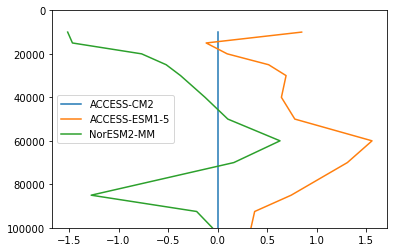

In [31]:
aw = {}
for model in cmip_info:
    z= cmip6[model][0].coord('air_pressure').points
    aw[model]=iris.analysis.cartography.area_weights(cmip6[model][0][:,:12])
    plt.plot(cmip6[model][0][:,:12].collapsed(['time','longitude','latitude'],iris.analysis.MEAN,weights=aw[model]).data#*(z[:12]/100000)**-0.286
              -cmip6['ACCESS-CM2'][0][:,:12].collapsed(['time','longitude','latitude'],iris.analysis.MEAN,weights=aw['ACCESS-CM2']).data,z[:12],label=model)
    plt.ylim(100000,0)

plt.legend()


In [25]:
z[:12]/100

array([1000.,  925.,  850.,  700.,  600.,  500.,  400.,  300.,  250.,
        200.,  150.,  100.])